<H3><b>Fine Tuning VVG16, VGG19, ResNet18, ResNet34 and ResNet50 by adding an Additional linear layer with 256 output features, ReLU activation and Dropout Layer of 50% Probability

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#necessary imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc

In [ ]:
# Define the number of classes in your dataset
num_classes = 2
dropout_prob = 0.5
criterion = nn.CrossEntropyLoss()
num_epochs=5

In [ ]:
#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#path to data folders
train_dir = '/content/drive/MyDrive/Colab Notebooks/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/test'
valid_dir = '/content/drive/MyDrive/Colab Notebooks/valid'

In [ ]:
#defining transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  #resize images to 224x224
        transforms.RandomHorizontalFlip(),  #randomly flip images horizontally
        transforms.ToTensor(),  #convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #normalize images
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
#load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
}

In [ ]:
#create DataLoader objects
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
}

In [ ]:
#print dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'valid']}
print("Dataset sizes:", dataset_sizes)

Dataset sizes: {'train': 2536, 'test': 300, 'valid': 100}


<H4><b>Model Training

In [ ]:
# Define function for training a model
def train_model(model, criterion, optimizer, dataloaders, num_epochs):
    model.to(device)
    train_acc_history = []
    valid_acc_history = []

    train_loss_history = []
    valid_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                valid_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                valid_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    return model, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

<h4><b>Model Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))


<h4><B>VGG16

In [ ]:
model_vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


In [ ]:
# Check the number of input features for the fully connected layer
num_features_vgg16 = model_vgg16.classifier[6].in_features


# Modify the fully connected layers
model_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(num_features_vgg16, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_vgg16 = model_vgg16.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg16.parameters(), lr=0.0001)
torch.cuda.empty_cache()
gc.collect()

20

In [ ]:
# Train the model
model_vgg16, train_acc_vgg16, valid_acc_vgg16, train_loss_vgg16, valid_loss_vgg16 = train_model(model_vgg16, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/5
----------
train Loss: 0.5406 Acc: 0.7181
valid Loss: 0.4668 Acc: 0.7900
Epoch 2/5
----------
train Loss: 0.3935 Acc: 0.8277
valid Loss: 0.4079 Acc: 0.8000
Epoch 3/5
----------
train Loss: 0.3691 Acc: 0.8316
valid Loss: 0.5234 Acc: 0.7800
Epoch 4/5
----------
train Loss: 0.3753 Acc: 0.8364
valid Loss: 0.4033 Acc: 0.8200
Epoch 5/5
----------
train Loss: 0.2449 Acc: 0.9038
valid Loss: 0.6174 Acc: 0.7800


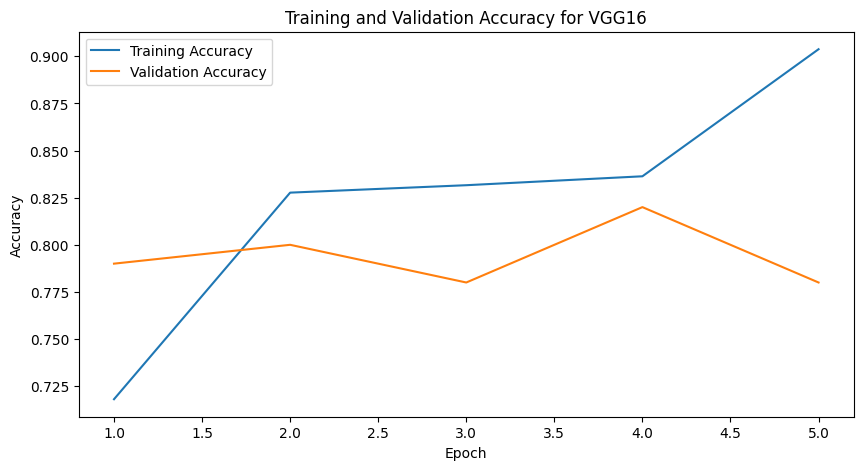

In [ ]:
# Move the accuracies to CPU
train_acc_vgg16_cpu = [acc.cpu().numpy() for acc in train_acc_vgg16]
valid_acc_vgg16_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg16]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg16_cpu) + 1), train_acc_vgg16_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg16_cpu) + 1), valid_acc_vgg16_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16')
plt.legend()
plt.show()

In [ ]:
print("Evaluating VGG16 on the test set...")
evaluate_model(model_vgg16, dataloaders['test'])

Evaluating VGG16 on the test set...
Accuracy: 0.8067
Precision: 0.7347
Recall: 0.9600
F1-score: 0.8324


<h4><B>VGG19

In [ ]:
model_vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 109MB/s] 


In [ ]:
# Check the number of input features for the fully connected layer
num_features_vgg19 = model_vgg19.classifier[6].in_features

# Modify the fully connected layers
model_vgg19.classifier[6] = nn.Sequential(
    nn.Linear(num_features_vgg19, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_vgg19 = model_vgg19.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_vgg19.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

4175

In [ ]:
# Train the model
model_vgg19, train_acc_vgg19, valid_acc_vgg19, train_loss_vgg19, valid_loss_vgg19 = train_model(model_vgg19, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/5
----------
train Loss: 0.5417 Acc: 0.7133
valid Loss: 0.5031 Acc: 0.7600
Epoch 2/5
----------
train Loss: 0.3931 Acc: 0.8277
valid Loss: 0.5046 Acc: 0.8000
Epoch 3/5
----------
train Loss: 0.3156 Acc: 0.8644
valid Loss: 0.4893 Acc: 0.8100
Epoch 4/5
----------
train Loss: 0.2755 Acc: 0.8864
valid Loss: 0.5139 Acc: 0.7800
Epoch 5/5
----------
train Loss: 0.2514 Acc: 0.8971
valid Loss: 0.4933 Acc: 0.7600


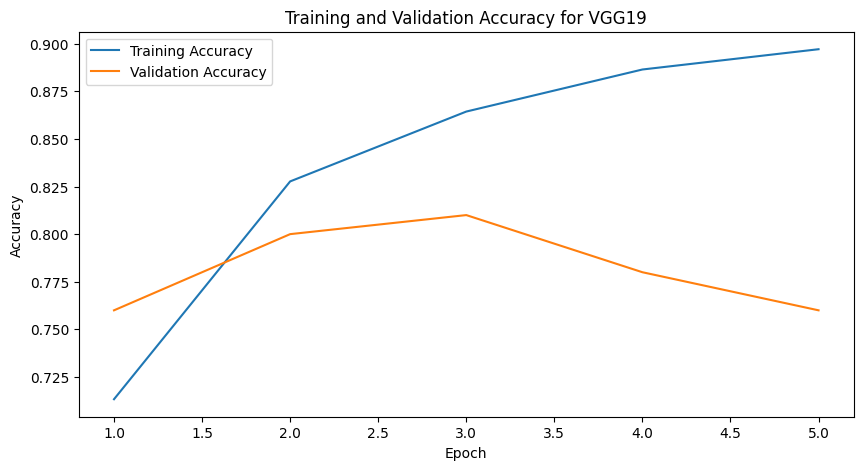

In [ ]:
# Move the accuracies to CPU
train_acc_vgg19_cpu = [acc.cpu().numpy() for acc in train_acc_vgg19]
valid_acc_vgg19_cpu = [acc.cpu().numpy() for acc in valid_acc_vgg19]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_vgg19_cpu) + 1), train_acc_vgg19_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_vgg19_cpu) + 1), valid_acc_vgg19_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG19')
plt.legend()
plt.show()

In [ ]:
print("Evaluating VGG19 on the test set...")
evaluate_model(model_vgg19, dataloaders['test'])

Evaluating VGG19 on the test set...
Accuracy: 0.8733
Precision: 0.8373
Recall: 0.9267
F1-score: 0.8797


<h4><b>ResNet18

In [ ]:
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


In [ ]:
# Modify the model head for fine-tuning
num_features_resnet18 = model_resnet18.fc.in_features


# Additional linear layer and dropout layer
model_resnet18.fc = nn.Sequential(
    nn.Linear(num_features_resnet18, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)


model_resnet18 = model_resnet18.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

9

In [ ]:
# Train the model
model_resnet18, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18  = train_model(model_resnet18, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/5
----------
train Loss: 0.4570 Acc: 0.7776
valid Loss: 0.5360 Acc: 0.7200
Epoch 2/5
----------
train Loss: 0.2701 Acc: 0.8908
valid Loss: 0.4511 Acc: 0.8100
Epoch 3/5
----------
train Loss: 0.1752 Acc: 0.9314
valid Loss: 0.3862 Acc: 0.8200
Epoch 4/5
----------
train Loss: 0.0970 Acc: 0.9673
valid Loss: 0.6564 Acc: 0.7600
Epoch 5/5
----------
train Loss: 0.0965 Acc: 0.9696
valid Loss: 0.4828 Acc: 0.8200


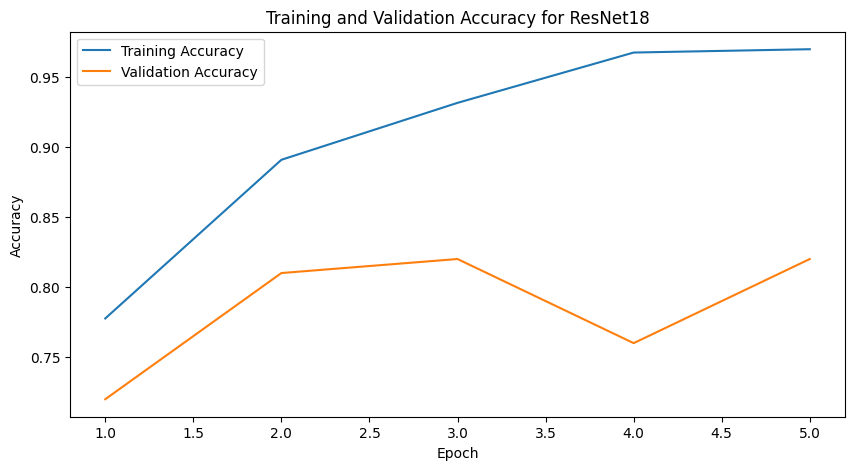

In [ ]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18')
plt.legend()
plt.show()

In [ ]:
print("Evaluating ResNet18 on the test set...")
evaluate_model(model_resnet18, dataloaders['test'])

Evaluating ResNet18 on the test set...
Accuracy: 0.8533
Precision: 0.9732
Recall: 0.7267
F1-score: 0.8321


<h4><b>ResNet34

In [ ]:
model_resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s]


In [ ]:
# Modify the model head for fine-tuning
num_features_resnet34 = model_resnet34.fc.in_features


# Additional linear layer and dropout layer
model_resnet34.fc = nn.Sequential(
    nn.Linear(num_features_resnet34, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

model_resnet34 = model_resnet34.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

9

In [ ]:
# Train the model
model_resnet34, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34  = train_model(model_resnet34, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/5
----------
train Loss: 0.4424 Acc: 0.7823
valid Loss: 0.4414 Acc: 0.8100
Epoch 2/5
----------
train Loss: 0.2466 Acc: 0.9073
valid Loss: 0.4626 Acc: 0.7800
Epoch 3/5
----------
train Loss: 0.1710 Acc: 0.9282
valid Loss: 0.4562 Acc: 0.8100
Epoch 4/5
----------
train Loss: 0.0976 Acc: 0.9657
valid Loss: 0.4564 Acc: 0.8300
Epoch 5/5
----------
train Loss: 0.0808 Acc: 0.9712
valid Loss: 0.4340 Acc: 0.8600


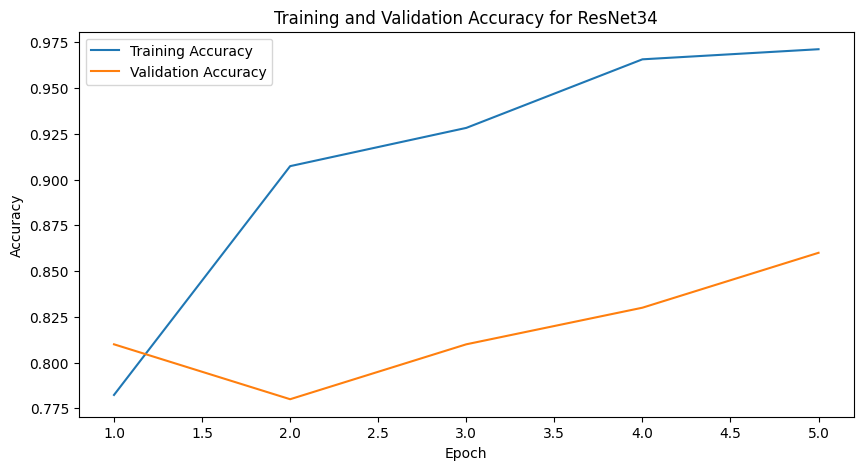

In [ ]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34')
plt.legend()
plt.show()

In [ ]:
print("Evaluating RestNet34 on the test set...")
evaluate_model(model_resnet34, dataloaders['test'])

Evaluating RestNet34 on the test set...
Accuracy: 0.8833
Precision: 0.9528
Recall: 0.8067
F1-score: 0.8736


<h4><b>ResNet50

In [ ]:
model_resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


In [ ]:
# Modify the model head for fine-tuning
num_features_resnet50 = model_resnet50.fc.in_features

# Additional linear layer and dropout layer
model_resnet50.fc = nn.Sequential(
    nn.Linear(num_features_resnet50, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function
    nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)


model_resnet50 = model_resnet50.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=0.0001)

torch.cuda.empty_cache()
gc.collect()

9

In [ ]:
# Train the model
model_resnet50, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model_resnet50, criterion, optimizer_ft, dataloaders,
                                                             num_epochs)

Epoch 1/5
----------
train Loss: 0.4550 Acc: 0.7812
valid Loss: 0.3784 Acc: 0.8800
Epoch 2/5
----------
train Loss: 0.2612 Acc: 0.8935
valid Loss: 0.3415 Acc: 0.8900
Epoch 3/5
----------
train Loss: 0.1619 Acc: 0.9389
valid Loss: 0.6199 Acc: 0.7800
Epoch 4/5
----------
train Loss: 0.1188 Acc: 0.9535
valid Loss: 0.4876 Acc: 0.8300
Epoch 5/5
----------
train Loss: 0.0942 Acc: 0.9645
valid Loss: 0.5357 Acc: 0.8600


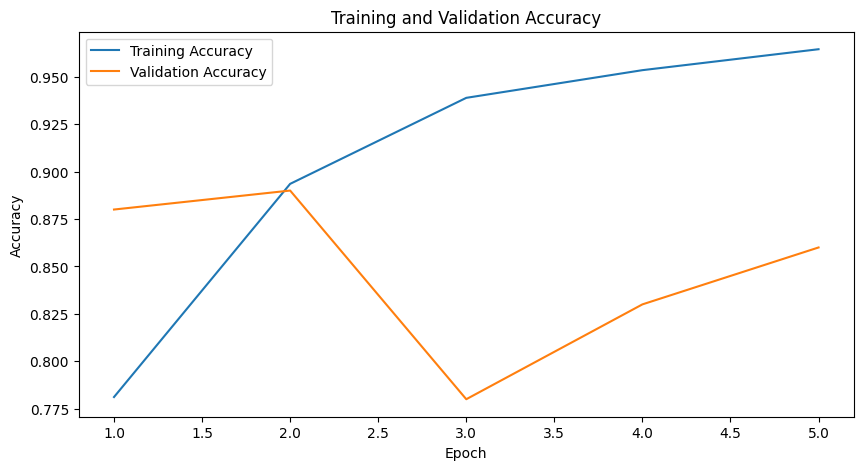

In [ ]:
import matplotlib.pyplot as plt

# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
print("Evaluating ResNet50 on the test set...")
evaluate_model(model_resnet50, dataloaders['test'])

Evaluating ResNet50 on the test set...
Accuracy: 0.8700
Precision: 0.8405
Recall: 0.9133
F1-score: 0.8754
